In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
# directory that contains pickle files
undoctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_pkl')
doctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_doctored_pkl')

# Helper functions

In [3]:
def data_generator(T, C, le, exclude_labels=[], max_per_class=None):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    counter = collections.Counter()
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels and (max_per_class is None or counter[L] < max_per_class):
            poses.append(p)
            labels.append(L)
            counter[L] += 1
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

In [5]:
def count_all_nan(X):
    return sum([np.count_nonzero(np.isnan(x)) for x in X])

## Load and Preprocess Data

In [6]:
# Load pickle files
Train_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_test_1.pkl"), "rb"))

Train_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_test_1.pkl"), "rb"))


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_undoctored['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


In [7]:
# examine some known strange videos
print(Train_undoctored.keys())
for p, L, filename in zip(Train_undoctored['pose'], Train_undoctored['label'], Train_undoctored['filename']):
    if 'Maddin_winkt_wave_h_cm_np1_fr_med_1' in filename:
        print(L, filename)
        print(p.dtype)
        print('Nose\n', p[:, 0, :])
        print('RElbow\n', p[:, 3, :])
        print('RWrist\n', p[:, 4, :])
        print('LElbow\n', p[:, 6, :])
        print('RWrist\n', p[:, 7, :])
        break

dict_keys(['pose', 'label', 'filename'])
wave wave/Maddin_winkt_wave_h_cm_np1_fr_med_1
float64
Nose
 [[217.41  111.526]
 [216.107 107.003]
 [205.713 106.334]
 [196.635 106.364]
 [197.279 106.35 ]
 [197.935 106.334]
 [198.586 106.337]
 [194.704 102.465]
 [193.385 102.465]
 [190.808 104.415]
 [190.808 104.416]
 [189.483  96.63 ]
 [193.388  95.314]
 [203.14   95.949]
 [217.418  94.665]
 [224.554  92.069]
 [225.851  92.065]
 [222.612  86.869]
 [221.977  92.076]
 [228.466  95.981]
 [231.706  96.606]
 [231.693  96.649]
 [231.06   96.64 ]
 [227.174 101.836]
 [227.805 106.336]
 [231.69  109.607]
 [232.365 110.902]
 [233.658 112.221]
 [234.944 112.222]
 [235.604 117.402]
 [234.309 117.38 ]
 [226.535 117.387]
 [221.956 121.958]
 [221.33  121.967]
 [226.492 119.36 ]
 [226.526 121.307]
 [226.538 120.659]
 [225.867 118.05 ]]
RElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

### Optionally Combine doctored and undoctored train/test

In [8]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=64)

X_doctored, Y_doctored = data_generator(Train_doctored,C,le)
X_undoctored, Y_undoctored = data_generator(Train_undoctored,C,le)

# print("Combine doctored and undoctored training sets!")
# X = X_doctored + X_undoctored
# Y = np.concatenate([Y_doctored, Y_undoctored])

X = X_undoctored
Y = Y_undoctored

# X = X_doctored
# Y = Y_doctored

X_test,Y_test = data_generator(Test_undoctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])
# X_test,Y_test = data_generator(Test_doctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

630 (30, 25, 2) (630, 21)
251 (31, 25, 2) (251, 21)


## Deal with undetected joints

### NANify undetection joints

In [9]:
cleaner = ddnet.OpenPoseDataCleaner(copy=True)

X_nan = list(map(cleaner.make_nan, X))
X_test_nan = list(map(cleaner.make_nan, X_test))

### Filter on visible subset of joints

In [10]:
RWrist, LWrist = 4, 7
RElbow, LElbow = 3, 6
RShoulder, LShoulder = 2, 5
MidHip = 8

def has_joint(p, joint, thresh=10):
    return np.count_nonzero(~np.isnan(p[:,joint, 0])) >= thresh

In [12]:
# Now let's filter the points with both hands visible

X_subset, Y_subset = zip(*[(x, y) for x,y in zip(X_nan, Y) \
                           if has_joint(x, RWrist) and has_joint(x, LWrist) \
                            and has_joint(x, RElbow) and has_joint(x, LElbow) \
                            and has_joint(x, RShoulder) and has_joint(x, LShoulder)])
Y_subset=np.array(Y_subset)

X_test_subset, Y_test_subset = zip(*[(x, y) for x,y in zip(X_test_nan, Y_test) \
                                     if has_joint(x, RWrist) and has_joint(x, LWrist) \
                                     and has_joint(x, RShoulder) and has_joint(x, LShoulder)])
Y_test_subset=np.array(Y_test_subset)

print(len(X), '->', len(X_subset))
print(len(X_test), '->', len(X_test_subset))

630 -> 480
251 -> 188


### Filter good joints, temporal interpolation and normalize (still have NANs)

In [13]:
X_clean = list(map(cleaner.transform_point, X_subset))
X_test_clean = list(map(cleaner.transform_point, X_test_subset))

In [14]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_clean[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0_nan, X_1_nan = ddnet.preprocess_batch(X_clean, C)
X_test_0_nan, X_test_1_nan = ddnet.preprocess_batch(X_test_clean, C)
print(X_0_nan[0].shape, X_1_nan[0].shape)

print(count_all_nan(X_clean))
print(count_all_nan(X_test_clean))
print(count_all_nan(X_0_nan), count_all_nan(X_1_nan))
print(count_all_nan(X_test_0_nan), count_all_nan(X_test_1_nan))

(32, 105) (32, 15, 2)
40264
14414
244064 37440
88672 13696


In [15]:
# impute JCD NAN's with mean
# print(X_0.shape)
# JCD_mean = np.nanmean(X_0, axis=(0,1))
# print(JCD_mean.shape, JCD_mean)

from sklearn.impute import SimpleImputer

# Impute JCD with mean
# imp_jcd = SimpleImputer(missing_values=np.nan, strategy='mean', copy=True)
# imp_jcd.fit(X_0_nan.reshape(-1, X_0_nan.shape[-1]))

# X_0_imp = np.array([imp_mean.transform(x) for x in X_0_nan])
# X_test_0_imp = np.array([imp_mean.transform(x) for x in X_test_0_nan])
# print(X_0_nan[0][0])
# print(X_0_imp[0][0])

# Impute JCD with 0
X_0_imp = X_0_nan.copy()
X_0_imp[np.isnan(X_0_imp)] = 0.
X_test_0_imp = X_test_0_nan.copy()
X_test_0_imp[np.isnan(X_test_0_imp)] = 0.
print(X_0_nan[0][0])
print(X_0_imp[0][0])


# Impute Cartessian with 0
X_1_imp = X_1_nan.copy()
X_1_imp[np.isnan(X_1_imp)] = 0.
X_test_1_imp = X_test_1_nan.copy()
X_test_1_imp[np.isnan(X_test_1_imp)] = 0.
print(X_1_nan[0][0])
print(X_1_imp[0][0])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.65950087 -0.12642284  0.35559673 -0.64442366
 -0.12598109  0.2508891   0.29156327  0.3293937   1.06008882  0.31034416
  1.08756844         nan         nan -0.28515897  0.25663624 -0.30404791
  0.0985716   0.3805516   0.33617743  0.31488398  1.05251784  0.41360095
  1.14400971         nan         nan -0.44713877  0.13668593  0.02164037
  0.01469042 -0.18725831 -0.30180534  0.40056135 -0.01250218  0.56892368
         nan         nan  0.54531851  0.14884868 -0.11876332 -0.4457569
 -0.66906255 -0.12419867 -0.20589118  0.11359826         nan         nan
 -0.24591002  0.21999861  0.35196385  0.44562351  1.1398      0.30590762
  1.10043431         nan         nan -0.50103164 -0.26257918 -0.08592249
  0.49095518 -0.39417049  0.38234921         nan         nan -0.66026607
 -0.43308903  0.00425622 -0.88018957 -0.11376807    

In [16]:
Y_input = Y_subset
Y_test_input = Y_test_subset
X_0, X_1 = X_0_imp, X_1_imp
X_test_0, X_test_1 = X_test_0_imp, X_test_1_imp
print(X_0.shape, X_1.shape)

(480, 32, 105) (480, 32, 15, 2)


# Train, Test 

### Reweight training samples

In [17]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [18]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[:10])

[15 33 22 25 30 16 19 16 32 31 16 24 17 32 21 18 13 35 23 23 19]
[2.33333333 1.06060606 1.59090909 1.4        1.16666667 2.1875
 1.84210526 2.1875     1.09375    1.12903226 2.1875     1.45833333
 2.05882353 1.09375    1.66666667 1.94444444 2.69230769 1.
 1.52173913 1.52173913 1.84210526]
(480,)
[1.84210526 1.84210526 1.84210526 1.84210526 1.84210526 1.84210526
 1.84210526 1.84210526 1.84210526 1.84210526]


### Train and plot loss/accuracy

In [25]:
random.seed(456)

DD_Net = ddnet.build_DD_Net(C)
DD_Net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 512)       1714816     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 512)          0           model_3[1][0]              

In [26]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=1000,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )


Train on 480 samples, validate on 188 samples
Epoch 1/1000
480/480 [==============================] - 5s 11ms/step - loss: 5.8882 - accuracy: 0.0437 - val_loss: 3.0440 - val_accuracy: 0.0638
Epoch 2/1000
480/480 [==============================] - 0s 161us/step - loss: 5.4592 - accuracy: 0.0542 - val_loss: 3.0430 - val_accuracy: 0.0638
Epoch 3/1000
480/480 [==============================] - 0s 163us/step - loss: 4.9475 - accuracy: 0.0771 - val_loss: 3.0411 - val_accuracy: 0.1170
Epoch 4/1000
480/480 [==============================] - 0s 171us/step - loss: 4.8780 - accuracy: 0.0896 - val_loss: 3.0392 - val_accuracy: 0.0691
Epoch 5/1000
480/480 [==============================] - 0s 164us/step - loss: 4.4879 - accuracy: 0.1187 - val_loss: 3.0373 - val_accuracy: 0.0691
Epoch 6/1000
480/480 [==============================] - 0s 163us/step - loss: 4.3505 - accuracy: 0.1688 - val_loss: 3.0351 - val_accuracy: 0.0585
Epoch 7/1000
480/480 [==============================] - 0s 157us/step - loss: 4

Epoch 57/1000
480/480 [==============================] - 0s 150us/step - loss: 0.9236 - accuracy: 0.8708 - val_loss: 2.9353 - val_accuracy: 0.1596
Epoch 58/1000
480/480 [==============================] - 0s 146us/step - loss: 0.8398 - accuracy: 0.8854 - val_loss: 2.9445 - val_accuracy: 0.1596
Epoch 59/1000
480/480 [==============================] - 0s 149us/step - loss: 0.7227 - accuracy: 0.9000 - val_loss: 2.9530 - val_accuracy: 0.1755
Epoch 60/1000
480/480 [==============================] - 0s 150us/step - loss: 0.8265 - accuracy: 0.8708 - val_loss: 2.9595 - val_accuracy: 0.1809
Epoch 61/1000
480/480 [==============================] - 0s 151us/step - loss: 0.7656 - accuracy: 0.8979 - val_loss: 2.9680 - val_accuracy: 0.1809
Epoch 62/1000
480/480 [==============================] - 0s 141us/step - loss: 0.7643 - accuracy: 0.8708 - val_loss: 2.9639 - val_accuracy: 0.1915
Epoch 63/1000
480/480 [==============================] - 0s 151us/step - loss: 0.6680 - accuracy: 0.9125 - val_loss: 2

Epoch 113/1000
480/480 [==============================] - 0s 164us/step - loss: 0.2287 - accuracy: 0.9854 - val_loss: 3.2415 - val_accuracy: 0.2181
Epoch 114/1000
480/480 [==============================] - 0s 157us/step - loss: 0.1961 - accuracy: 0.9792 - val_loss: 3.2173 - val_accuracy: 0.2234
Epoch 115/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1938 - accuracy: 0.9833 - val_loss: 3.2067 - val_accuracy: 0.2234
Epoch 116/1000
480/480 [==============================] - 0s 156us/step - loss: 0.1707 - accuracy: 0.9937 - val_loss: 3.2004 - val_accuracy: 0.2287
Epoch 117/1000
480/480 [==============================] - 0s 151us/step - loss: 0.1961 - accuracy: 0.9833 - val_loss: 3.1986 - val_accuracy: 0.2287
Epoch 118/1000
480/480 [==============================] - 0s 148us/step - loss: 0.1968 - accuracy: 0.9833 - val_loss: 3.2093 - val_accuracy: 0.2287
Epoch 119/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1765 - accuracy: 0.9917 - val_

Epoch 169/1000
480/480 [==============================] - 0s 152us/step - loss: 0.1240 - accuracy: 0.9979 - val_loss: 3.0756 - val_accuracy: 0.2979
Epoch 170/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1446 - accuracy: 0.9917 - val_loss: 3.0711 - val_accuracy: 0.2979
Epoch 171/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1330 - accuracy: 0.9979 - val_loss: 3.0668 - val_accuracy: 0.2979
Epoch 172/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1202 - accuracy: 0.9979 - val_loss: 3.0627 - val_accuracy: 0.2979
Epoch 173/1000
480/480 [==============================] - 0s 163us/step - loss: 0.1506 - accuracy: 0.9958 - val_loss: 3.0583 - val_accuracy: 0.3032
Epoch 174/1000
480/480 [==============================] - 0s 160us/step - loss: 0.1377 - accuracy: 0.9958 - val_loss: 3.0530 - val_accuracy: 0.2979
Epoch 175/1000
480/480 [==============================] - 0s 150us/step - loss: 0.1305 - accuracy: 0.9979 - val_

Epoch 225/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1173 - accuracy: 0.9937 - val_loss: 2.7693 - val_accuracy: 0.3404
Epoch 226/1000
480/480 [==============================] - 0s 161us/step - loss: 0.1380 - accuracy: 0.9937 - val_loss: 2.7629 - val_accuracy: 0.3404
Epoch 227/1000
480/480 [==============================] - 0s 163us/step - loss: 0.1313 - accuracy: 0.9917 - val_loss: 2.7571 - val_accuracy: 0.3404
Epoch 228/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1375 - accuracy: 0.9937 - val_loss: 2.7514 - val_accuracy: 0.3457
Epoch 229/1000
480/480 [==============================] - 0s 163us/step - loss: 0.1219 - accuracy: 0.9958 - val_loss: 2.7456 - val_accuracy: 0.3457
Epoch 230/1000
480/480 [==============================] - 0s 167us/step - loss: 0.1433 - accuracy: 0.9958 - val_loss: 2.7395 - val_accuracy: 0.3457
Epoch 231/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1341 - accuracy: 0.9979 - val_

Epoch 281/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1324 - accuracy: 0.9917 - val_loss: 2.4257 - val_accuracy: 0.4202
Epoch 282/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1353 - accuracy: 0.9979 - val_loss: 2.4191 - val_accuracy: 0.4255
Epoch 283/1000
480/480 [==============================] - 0s 141us/step - loss: 0.1225 - accuracy: 0.9979 - val_loss: 2.4125 - val_accuracy: 0.4255
Epoch 284/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1192 - accuracy: 0.9958 - val_loss: 2.4063 - val_accuracy: 0.4255
Epoch 285/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1891 - accuracy: 0.9833 - val_loss: 2.3999 - val_accuracy: 0.4255
Epoch 286/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1214 - accuracy: 1.0000 - val_loss: 2.3939 - val_accuracy: 0.4309
Epoch 287/1000
480/480 [==============================] - 0s 157us/step - loss: 0.1296 - accuracy: 0.9937 - val_

Epoch 337/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1429 - accuracy: 0.9917 - val_loss: 2.0971 - val_accuracy: 0.4574
Epoch 338/1000
480/480 [==============================] - 0s 174us/step - loss: 0.1363 - accuracy: 0.9854 - val_loss: 2.0915 - val_accuracy: 0.4628
Epoch 339/1000
480/480 [==============================] - 0s 147us/step - loss: 0.1268 - accuracy: 1.0000 - val_loss: 2.0861 - val_accuracy: 0.4681
Epoch 340/1000
480/480 [==============================] - 0s 151us/step - loss: 0.1149 - accuracy: 0.9958 - val_loss: 2.0810 - val_accuracy: 0.4681
Epoch 341/1000
480/480 [==============================] - 0s 144us/step - loss: 0.1017 - accuracy: 0.9979 - val_loss: 2.0752 - val_accuracy: 0.4681
Epoch 342/1000
480/480 [==============================] - 0s 145us/step - loss: 0.1181 - accuracy: 0.9979 - val_loss: 2.0703 - val_accuracy: 0.4681
Epoch 343/1000
480/480 [==============================] - 0s 150us/step - loss: 0.1263 - accuracy: 0.9958 - val_

Epoch 393/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1091 - accuracy: 0.9937 - val_loss: 1.7898 - val_accuracy: 0.5160
Epoch 394/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1328 - accuracy: 0.9875 - val_loss: 1.7848 - val_accuracy: 0.5160
Epoch 395/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1269 - accuracy: 0.9917 - val_loss: 1.7794 - val_accuracy: 0.5213
Epoch 396/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1306 - accuracy: 0.9958 - val_loss: 1.7744 - val_accuracy: 0.5213
Epoch 397/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1218 - accuracy: 1.0000 - val_loss: 1.7693 - val_accuracy: 0.5266
Epoch 398/1000
480/480 [==============================] - 0s 157us/step - loss: 0.1255 - accuracy: 0.9979 - val_loss: 1.7639 - val_accuracy: 0.5319
Epoch 399/1000
480/480 [==============================] - 0s 150us/step - loss: 0.1313 - accuracy: 0.9917 - val_

Epoch 449/1000
480/480 [==============================] - 0s 173us/step - loss: 0.1330 - accuracy: 0.9937 - val_loss: 1.5311 - val_accuracy: 0.6117
Epoch 450/1000
480/480 [==============================] - 0s 177us/step - loss: 0.1243 - accuracy: 0.9937 - val_loss: 1.5275 - val_accuracy: 0.6117
Epoch 451/1000
480/480 [==============================] - 0s 181us/step - loss: 0.1100 - accuracy: 1.0000 - val_loss: 1.5238 - val_accuracy: 0.6117
Epoch 452/1000
480/480 [==============================] - 0s 161us/step - loss: 0.1426 - accuracy: 0.9917 - val_loss: 1.5206 - val_accuracy: 0.6117
Epoch 453/1000
480/480 [==============================] - 0s 146us/step - loss: 0.1291 - accuracy: 0.9958 - val_loss: 1.5174 - val_accuracy: 0.6117
Epoch 454/1000
480/480 [==============================] - 0s 147us/step - loss: 0.1164 - accuracy: 1.0000 - val_loss: 1.5141 - val_accuracy: 0.6117
Epoch 455/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1109 - accuracy: 0.9937 - val_

Epoch 505/1000
480/480 [==============================] - 0s 171us/step - loss: 0.1228 - accuracy: 0.9958 - val_loss: 1.3701 - val_accuracy: 0.6649
Epoch 506/1000
480/480 [==============================] - 0s 169us/step - loss: 0.1252 - accuracy: 0.9937 - val_loss: 1.3681 - val_accuracy: 0.6702
Epoch 507/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1483 - accuracy: 0.9854 - val_loss: 1.3659 - val_accuracy: 0.6702
Epoch 508/1000
480/480 [==============================] - 0s 170us/step - loss: 0.1372 - accuracy: 0.9937 - val_loss: 1.3638 - val_accuracy: 0.6702
Epoch 509/1000
480/480 [==============================] - 0s 164us/step - loss: 0.1185 - accuracy: 0.9958 - val_loss: 1.3614 - val_accuracy: 0.6702
Epoch 510/1000
480/480 [==============================] - 0s 166us/step - loss: 0.1128 - accuracy: 1.0000 - val_loss: 1.3594 - val_accuracy: 0.6702
Epoch 511/1000
480/480 [==============================] - 0s 156us/step - loss: 0.1187 - accuracy: 1.0000 - val_

Epoch 561/1000
480/480 [==============================] - 0s 144us/step - loss: 0.1292 - accuracy: 0.9958 - val_loss: 1.2687 - val_accuracy: 0.6702
Epoch 562/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1134 - accuracy: 0.9979 - val_loss: 1.2670 - val_accuracy: 0.6702
Epoch 563/1000
480/480 [==============================] - 0s 162us/step - loss: 0.1195 - accuracy: 0.9958 - val_loss: 1.2653 - val_accuracy: 0.6702
Epoch 564/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1222 - accuracy: 0.9979 - val_loss: 1.2636 - val_accuracy: 0.6702
Epoch 565/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1176 - accuracy: 0.9958 - val_loss: 1.2621 - val_accuracy: 0.6702
Epoch 566/1000
480/480 [==============================] - 0s 150us/step - loss: 0.1220 - accuracy: 0.9937 - val_loss: 1.2606 - val_accuracy: 0.6702
Epoch 567/1000
480/480 [==============================] - 0s 151us/step - loss: 0.1112 - accuracy: 0.9896 - val_

Epoch 617/1000
480/480 [==============================] - 0s 162us/step - loss: 0.1490 - accuracy: 0.9917 - val_loss: 1.2157 - val_accuracy: 0.6649
Epoch 618/1000
480/480 [==============================] - 0s 157us/step - loss: 0.1074 - accuracy: 0.9958 - val_loss: 1.2147 - val_accuracy: 0.6596
Epoch 619/1000
480/480 [==============================] - 0s 163us/step - loss: 0.1054 - accuracy: 0.9979 - val_loss: 1.2139 - val_accuracy: 0.6596
Epoch 620/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1028 - accuracy: 0.9979 - val_loss: 1.2132 - val_accuracy: 0.6596
Epoch 621/1000
480/480 [==============================] - 0s 152us/step - loss: 0.1470 - accuracy: 0.9979 - val_loss: 1.2126 - val_accuracy: 0.6596
Epoch 622/1000
480/480 [==============================] - 0s 160us/step - loss: 0.1135 - accuracy: 0.9958 - val_loss: 1.2119 - val_accuracy: 0.6596
Epoch 623/1000
480/480 [==============================] - 0s 159us/step - loss: 0.0986 - accuracy: 0.9958 - val_

Epoch 673/1000
480/480 [==============================] - 0s 142us/step - loss: 0.1246 - accuracy: 0.9937 - val_loss: 1.1893 - val_accuracy: 0.6702
Epoch 674/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1186 - accuracy: 1.0000 - val_loss: 1.1889 - val_accuracy: 0.6702
Epoch 675/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1396 - accuracy: 0.9937 - val_loss: 1.1885 - val_accuracy: 0.6702
Epoch 676/1000
480/480 [==============================] - 0s 170us/step - loss: 0.1171 - accuracy: 0.9979 - val_loss: 1.1882 - val_accuracy: 0.6702
Epoch 677/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1236 - accuracy: 0.9979 - val_loss: 1.1880 - val_accuracy: 0.6702
Epoch 678/1000
480/480 [==============================] - 0s 148us/step - loss: 0.1039 - accuracy: 0.9958 - val_loss: 1.1876 - val_accuracy: 0.6702
Epoch 679/1000
480/480 [==============================] - 0s 136us/step - loss: 0.1336 - accuracy: 0.9896 - val_

Epoch 729/1000
480/480 [==============================] - 0s 151us/step - loss: 0.1505 - accuracy: 0.9854 - val_loss: 1.1759 - val_accuracy: 0.6755
Epoch 730/1000
480/480 [==============================] - 0s 160us/step - loss: 0.1253 - accuracy: 0.9937 - val_loss: 1.1760 - val_accuracy: 0.6755
Epoch 731/1000
480/480 [==============================] - 0s 144us/step - loss: 0.1248 - accuracy: 0.9896 - val_loss: 1.1761 - val_accuracy: 0.6755
Epoch 732/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1274 - accuracy: 0.9917 - val_loss: 1.1761 - val_accuracy: 0.6755
Epoch 733/1000
480/480 [==============================] - 0s 152us/step - loss: 0.1093 - accuracy: 0.9958 - val_loss: 1.1761 - val_accuracy: 0.6755
Epoch 734/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1231 - accuracy: 0.9937 - val_loss: 1.1760 - val_accuracy: 0.6755
Epoch 735/1000
480/480 [==============================] - 0s 151us/step - loss: 0.1137 - accuracy: 1.0000 - val_

Epoch 785/1000
480/480 [==============================] - 0s 151us/step - loss: 0.0926 - accuracy: 0.9979 - val_loss: 1.1747 - val_accuracy: 0.6809
Epoch 786/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1173 - accuracy: 0.9958 - val_loss: 1.1750 - val_accuracy: 0.6809
Epoch 787/1000
480/480 [==============================] - 0s 155us/step - loss: 0.1076 - accuracy: 0.9979 - val_loss: 1.1751 - val_accuracy: 0.6809
Epoch 788/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1144 - accuracy: 0.9958 - val_loss: 1.1751 - val_accuracy: 0.6809
Epoch 789/1000
480/480 [==============================] - 0s 154us/step - loss: 0.1360 - accuracy: 0.9875 - val_loss: 1.1752 - val_accuracy: 0.6809
Epoch 790/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1226 - accuracy: 0.9937 - val_loss: 1.1753 - val_accuracy: 0.6809
Epoch 791/1000
480/480 [==============================] - 0s 149us/step - loss: 0.1035 - accuracy: 0.9979 - val_

Epoch 841/1000
480/480 [==============================] - 0s 161us/step - loss: 0.1314 - accuracy: 0.9958 - val_loss: 1.1679 - val_accuracy: 0.6702
Epoch 842/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1034 - accuracy: 0.9979 - val_loss: 1.1676 - val_accuracy: 0.6702
Epoch 843/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1276 - accuracy: 0.9917 - val_loss: 1.1674 - val_accuracy: 0.6702
Epoch 844/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1304 - accuracy: 0.9917 - val_loss: 1.1672 - val_accuracy: 0.6702
Epoch 845/1000
480/480 [==============================] - 0s 150us/step - loss: 0.1079 - accuracy: 0.9979 - val_loss: 1.1670 - val_accuracy: 0.6702
Epoch 846/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1150 - accuracy: 0.9937 - val_loss: 1.1670 - val_accuracy: 0.6702
Epoch 847/1000
480/480 [==============================] - 0s 152us/step - loss: 0.0925 - accuracy: 0.9979 - val_

Epoch 897/1000
480/480 [==============================] - 0s 150us/step - loss: 0.0970 - accuracy: 0.9979 - val_loss: 1.1619 - val_accuracy: 0.6809
Epoch 898/1000
480/480 [==============================] - 0s 165us/step - loss: 0.1036 - accuracy: 0.9958 - val_loss: 1.1621 - val_accuracy: 0.6809
Epoch 899/1000
480/480 [==============================] - 0s 162us/step - loss: 0.1034 - accuracy: 0.9979 - val_loss: 1.1622 - val_accuracy: 0.6809
Epoch 900/1000
480/480 [==============================] - 0s 166us/step - loss: 0.1162 - accuracy: 0.9958 - val_loss: 1.1624 - val_accuracy: 0.6809
Epoch 901/1000
480/480 [==============================] - 0s 161us/step - loss: 0.1064 - accuracy: 0.9979 - val_loss: 1.1625 - val_accuracy: 0.6809
Epoch 902/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1108 - accuracy: 0.9979 - val_loss: 1.1628 - val_accuracy: 0.6862
Epoch 903/1000
480/480 [==============================] - 0s 148us/step - loss: 0.1098 - accuracy: 0.9958 - val_

Epoch 953/1000
480/480 [==============================] - 0s 159us/step - loss: 0.1004 - accuracy: 1.0000 - val_loss: 1.1682 - val_accuracy: 0.6809
Epoch 954/1000
480/480 [==============================] - 0s 162us/step - loss: 0.1020 - accuracy: 1.0000 - val_loss: 1.1681 - val_accuracy: 0.6809
Epoch 955/1000
480/480 [==============================] - 0s 158us/step - loss: 0.1022 - accuracy: 0.9958 - val_loss: 1.1681 - val_accuracy: 0.6809
Epoch 956/1000
480/480 [==============================] - 0s 171us/step - loss: 0.1106 - accuracy: 0.9937 - val_loss: 1.1682 - val_accuracy: 0.6755
Epoch 957/1000
480/480 [==============================] - 0s 153us/step - loss: 0.1100 - accuracy: 0.9937 - val_loss: 1.1682 - val_accuracy: 0.6755
Epoch 958/1000
480/480 [==============================] - 0s 150us/step - loss: 0.0974 - accuracy: 1.0000 - val_loss: 1.1681 - val_accuracy: 0.6755
Epoch 959/1000
480/480 [==============================] - 0s 147us/step - loss: 0.1034 - accuracy: 0.9937 - val_

Epoch 9/400
480/480 [==============================] - 0s 154us/step - loss: 0.1028 - accuracy: 0.9979 - val_loss: 1.1924 - val_accuracy: 0.6809
Epoch 10/400
480/480 [==============================] - 0s 160us/step - loss: 0.1125 - accuracy: 0.9979 - val_loss: 1.1936 - val_accuracy: 0.6862
Epoch 11/400
480/480 [==============================] - 0s 151us/step - loss: 0.1123 - accuracy: 0.9937 - val_loss: 1.1964 - val_accuracy: 0.6809
Epoch 12/400
480/480 [==============================] - 0s 161us/step - loss: 0.1173 - accuracy: 0.9979 - val_loss: 1.2006 - val_accuracy: 0.6755
Epoch 13/400
480/480 [==============================] - 0s 149us/step - loss: 0.0945 - accuracy: 0.9979 - val_loss: 1.2028 - val_accuracy: 0.6755
Epoch 14/400
480/480 [==============================] - 0s 156us/step - loss: 0.1206 - accuracy: 0.9917 - val_loss: 1.2032 - val_accuracy: 0.6755
Epoch 15/400
480/480 [==============================] - 0s 159us/step - loss: 0.1007 - accuracy: 0.9958 - val_loss: 1.2029 - 

Epoch 66/400
480/480 [==============================] - 0s 160us/step - loss: 0.1035 - accuracy: 1.0000 - val_loss: 1.1923 - val_accuracy: 0.6809
Epoch 67/400
480/480 [==============================] - 0s 158us/step - loss: 0.0863 - accuracy: 0.9979 - val_loss: 1.1921 - val_accuracy: 0.6809
Epoch 68/400
480/480 [==============================] - 0s 156us/step - loss: 0.1022 - accuracy: 0.9917 - val_loss: 1.1918 - val_accuracy: 0.6809
Epoch 69/400
480/480 [==============================] - 0s 156us/step - loss: 0.0892 - accuracy: 0.9958 - val_loss: 1.1918 - val_accuracy: 0.6809
Epoch 70/400
480/480 [==============================] - 0s 151us/step - loss: 0.1106 - accuracy: 0.9917 - val_loss: 1.1914 - val_accuracy: 0.6809
Epoch 71/400
480/480 [==============================] - 0s 159us/step - loss: 0.0867 - accuracy: 1.0000 - val_loss: 1.1913 - val_accuracy: 0.6809
Epoch 72/400
480/480 [==============================] - 0s 154us/step - loss: 0.0978 - accuracy: 0.9979 - val_loss: 1.1912 -

Epoch 122/400
480/480 [==============================] - 0s 159us/step - loss: 0.1110 - accuracy: 0.9854 - val_loss: 1.1923 - val_accuracy: 0.6702
Epoch 123/400
480/480 [==============================] - 0s 159us/step - loss: 0.0803 - accuracy: 0.9979 - val_loss: 1.1923 - val_accuracy: 0.6702
Epoch 124/400
480/480 [==============================] - 0s 161us/step - loss: 0.1120 - accuracy: 0.9958 - val_loss: 1.1924 - val_accuracy: 0.6702
Epoch 125/400
480/480 [==============================] - 0s 156us/step - loss: 0.0849 - accuracy: 0.9979 - val_loss: 1.1926 - val_accuracy: 0.6702
Epoch 126/400
480/480 [==============================] - 0s 155us/step - loss: 0.0895 - accuracy: 0.9979 - val_loss: 1.1926 - val_accuracy: 0.6702
Epoch 127/400
480/480 [==============================] - 0s 157us/step - loss: 0.0964 - accuracy: 1.0000 - val_loss: 1.1925 - val_accuracy: 0.6702
Epoch 128/400
480/480 [==============================] - 0s 159us/step - loss: 0.0879 - accuracy: 0.9958 - val_loss: 1

Epoch 178/400
480/480 [==============================] - 0s 142us/step - loss: 0.0792 - accuracy: 0.9958 - val_loss: 1.1930 - val_accuracy: 0.6755
Epoch 179/400
480/480 [==============================] - 0s 155us/step - loss: 0.1227 - accuracy: 0.9937 - val_loss: 1.1929 - val_accuracy: 0.6755
Epoch 180/400
480/480 [==============================] - 0s 151us/step - loss: 0.0967 - accuracy: 0.9979 - val_loss: 1.1930 - val_accuracy: 0.6755
Epoch 181/400
480/480 [==============================] - 0s 159us/step - loss: 0.0983 - accuracy: 0.9958 - val_loss: 1.1931 - val_accuracy: 0.6755
Epoch 182/400
480/480 [==============================] - 0s 165us/step - loss: 0.0882 - accuracy: 0.9958 - val_loss: 1.1932 - val_accuracy: 0.6755
Epoch 183/400
480/480 [==============================] - 0s 162us/step - loss: 0.0962 - accuracy: 0.9979 - val_loss: 1.1932 - val_accuracy: 0.6755
Epoch 184/400
480/480 [==============================] - 0s 159us/step - loss: 0.0852 - accuracy: 0.9958 - val_loss: 1

Epoch 234/400
480/480 [==============================] - 0s 170us/step - loss: 0.1055 - accuracy: 0.9917 - val_loss: 1.1881 - val_accuracy: 0.6755
Epoch 235/400
480/480 [==============================] - 0s 194us/step - loss: 0.0976 - accuracy: 1.0000 - val_loss: 1.1880 - val_accuracy: 0.6755
Epoch 236/400
480/480 [==============================] - 0s 181us/step - loss: 0.0825 - accuracy: 1.0000 - val_loss: 1.1880 - val_accuracy: 0.6755
Epoch 237/400
480/480 [==============================] - 0s 173us/step - loss: 0.1069 - accuracy: 0.9958 - val_loss: 1.1878 - val_accuracy: 0.6755
Epoch 238/400
480/480 [==============================] - 0s 184us/step - loss: 0.1069 - accuracy: 0.9979 - val_loss: 1.1876 - val_accuracy: 0.6755
Epoch 239/400
480/480 [==============================] - 0s 169us/step - loss: 0.0929 - accuracy: 1.0000 - val_loss: 1.1876 - val_accuracy: 0.6755
Epoch 240/400
480/480 [==============================] - 0s 172us/step - loss: 0.0899 - accuracy: 0.9958 - val_loss: 1

Epoch 290/400
480/480 [==============================] - 0s 180us/step - loss: 0.0898 - accuracy: 0.9979 - val_loss: 1.1825 - val_accuracy: 0.6755
Epoch 291/400
480/480 [==============================] - 0s 173us/step - loss: 0.0698 - accuracy: 1.0000 - val_loss: 1.1825 - val_accuracy: 0.6755
Epoch 292/400
480/480 [==============================] - 0s 184us/step - loss: 0.0926 - accuracy: 0.9958 - val_loss: 1.1825 - val_accuracy: 0.6755
Epoch 293/400
480/480 [==============================] - 0s 210us/step - loss: 0.0722 - accuracy: 1.0000 - val_loss: 1.1827 - val_accuracy: 0.6755
Epoch 294/400
480/480 [==============================] - 0s 184us/step - loss: 0.0985 - accuracy: 0.9958 - val_loss: 1.1830 - val_accuracy: 0.6755
Epoch 295/400
480/480 [==============================] - 0s 197us/step - loss: 0.1124 - accuracy: 0.9958 - val_loss: 1.1832 - val_accuracy: 0.6755
Epoch 296/400
480/480 [==============================] - 0s 194us/step - loss: 0.0959 - accuracy: 0.9937 - val_loss: 1

Epoch 346/400
480/480 [==============================] - 0s 167us/step - loss: 0.1158 - accuracy: 0.9896 - val_loss: 1.1857 - val_accuracy: 0.6809
Epoch 347/400
480/480 [==============================] - 0s 164us/step - loss: 0.1046 - accuracy: 0.9979 - val_loss: 1.1858 - val_accuracy: 0.6809
Epoch 348/400
480/480 [==============================] - 0s 156us/step - loss: 0.0894 - accuracy: 0.9979 - val_loss: 1.1860 - val_accuracy: 0.6809
Epoch 349/400
480/480 [==============================] - 0s 167us/step - loss: 0.0745 - accuracy: 0.9979 - val_loss: 1.1862 - val_accuracy: 0.6755
Epoch 350/400
480/480 [==============================] - 0s 167us/step - loss: 0.1041 - accuracy: 1.0000 - val_loss: 1.1864 - val_accuracy: 0.6755
Epoch 351/400
480/480 [==============================] - 0s 190us/step - loss: 0.0982 - accuracy: 0.9979 - val_loss: 1.1863 - val_accuracy: 0.6755
Epoch 352/400
480/480 [==============================] - 0s 172us/step - loss: 0.0905 - accuracy: 0.9979 - val_loss: 1

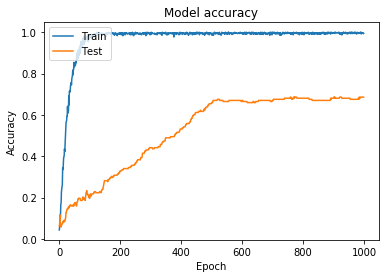

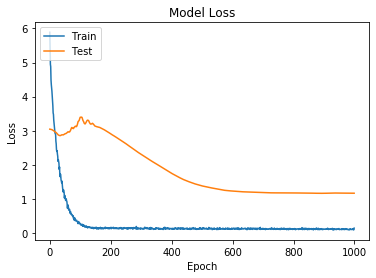

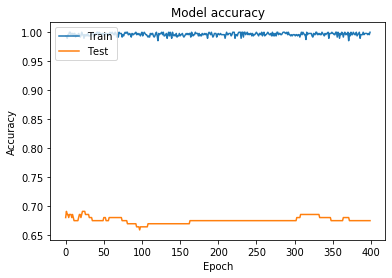

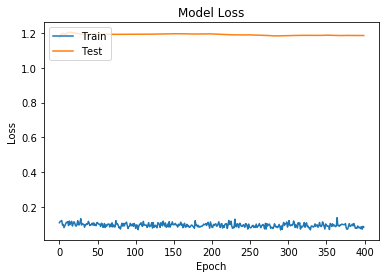

In [27]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [28]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

[[ 3  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0  1  0  0]
 [ 1  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  1  0]
 [ 0  1  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  2  0  1  0  1  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  4  0  0  0  0  2  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  7  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  1  0  0  0  4  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  2  0  0  0  1  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0 13  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  2  1  0  0  5  0  0  0  0  0  0]
 [ 0  0  0

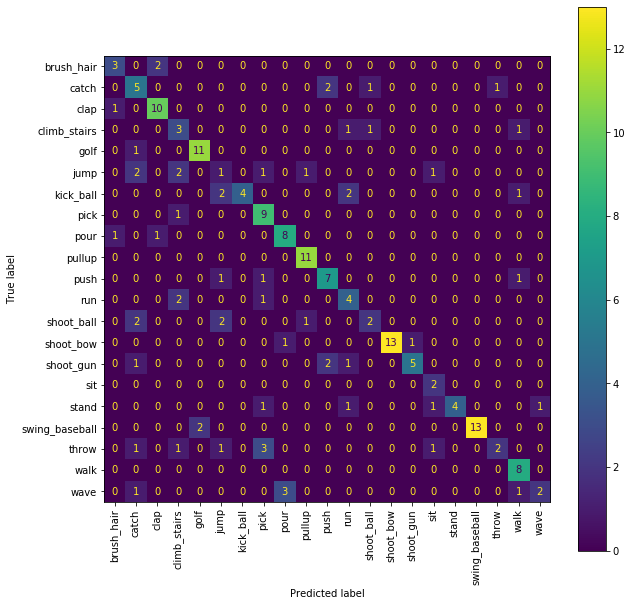

In [29]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_) #sorted(set(le.inverse_transform(Y_test_cls))))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

In [30]:
# other statistics
import pandas as pd
from sklearn.metrics import average_precision_score

df = pd.DataFrame()

for i, cls_name in enumerate(le.classes_):
    precision = np.round(cm[i, i] / np.sum(cm[:, i]), 2)
    recall = np.round(cm[i, i] / np.sum(cm[i, :]), 2)
    train_size =  list(le.inverse_transform(np.argmax(Y_input, axis=1))).count(cls_name)
    test_size =  list(le.inverse_transform(np.argmax(Y_test_input, axis=1))).count(cls_name)

    ap = average_precision_score(Y_test_input[:, i], Y_test_pred[:, i])
        
    df = df.append({
        'class_name': cls_name,
        'precision': precision,
        'recall': recall,
        'train_size': train_size,
        'test_size': test_size,
        '1-vs-all AP': ap 
    }, ignore_index=True)

print(df.round(3))

    1-vs-all AP      class_name  precision  recall  test_size  train_size
0         0.567      brush_hair       0.60    0.60        5.0        15.0
1         0.433           catch       0.38    0.56        9.0        33.0
2         0.947            clap       0.77    0.91       11.0        22.0
3         0.369    climb_stairs       0.33    0.50        6.0        25.0
4         0.994            golf       0.85    0.92       12.0        30.0
5         0.196            jump       0.14    0.12        8.0        16.0
6         0.866       kick_ball       1.00    0.44        9.0        19.0
7         0.823            pick       0.56    0.90       10.0        16.0
8         0.799            pour       0.67    0.80       10.0        32.0
9         1.000          pullup       0.85    1.00       11.0        31.0
10        0.687            push       0.64    0.70       10.0        16.0
11        0.569             run       0.44    0.57        7.0        24.0
12        0.523      shoot_ball       

### Save model to disk

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Examine wrong predictions

In [ ]:
def check_labels(Y_true, Y_pred, le, filenames, labels=['wave']):
    assert Y_true.shape[0] == Y_pred.shape[0] == len(filenames)
    for yt, yp, fn in zip(Y_true, Y_pred, filenames):
        cls_true = np.argmax(yt)
        cls_pred = np.argmax(yp)
        if le.inverse_transform([cls_true])[0] in labels:
            correct = (cls_true == cls_pred)
            print("{} \t{}={:.2f} \t{}={:.2f} \t{}".format(
                correct,
                le.inverse_transform([cls_pred])[0],
                np.max(yp),
                labels[0],
                yp[cls_true],
                fn
            ))
            
check_labels(Y_test_input, Y_test_pred, le, Test_undoctored['filename'])

### Refit using Training + Test Data

In [ ]:
print(Y_input.shape, Y_test_input.shape)
X_refit = X_input + X_test_input
Y_refit = np.concatenate([Y_input, Y_test_input])
assert len(X_refit) == Y_refit.shape[0]
print(len(X_refit))
refit_sample_weight = get_sample_weight(Y_refit)

In [ ]:
X_refit_0, X_refit_1 = ddnet.preprocess_batch(X_refit, C)

In [ ]:
# create a new net
refit_net = ddnet.create_DDNet(C)

lr = 1e-3
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )

lr = 1e-4
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )


In [ ]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [ ]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10_refit.h5'
ddnet.save_DDNet(refit_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)